# Exercise 2. (25p)

 In this exercise you will work on the image coffeebeans.jpeg as showed in Figure 3.

There are shadows around each coffee bean and clove. Experiment with some techniques you have learned in the course and **try to eliminate the shadows** as much as you can.

1. Describe the techniques you use and explain how they work. Show images with results and intermediate results. (5p)


5. Can you compute the size of the coffee beans? Explain how and/or why it is challenging. (5p)



2. Create a mask of the beans and cloves and compute images of the beans and the cloves like showed in Figure 4. One with shadows included and one without. (5p)

# Task2: Masking


#Mask
image → Duplicate\
image → type → 8 bit\
Process → enhance contrast\
image → adjust → auto-thershold-triangle\
Edit  →  invert (Fill holes work only on white-objects)\
Process → binary → fill holes\
Edit  →  invert (Object black-0, background-255)\

Processs → Image calculator→  add :(1st image-Original, 2nd image- the mask)

# Task3: Bean Counting
We want to count only the coffee beans. Try to make a selection so that you only count the coffee beans and not the cloves. (5p)

In [1]:
#Importing the necessary modules
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

# For binarising
from skimage.filters import try_all_threshold, threshold_otsu, threshold_mean

# For watershed
from scipy import ndimage as ndi#for distance
from skimage.feature import peak_local_max 
from skimage.segmentation import watershed 
from skimage import measure #measure objects
from skimage.morphology import remove_small_holes # for filling the holes and denoising

# For making boxex around the beans
from matplotlib.patches import Rectangle

In [2]:
def get_image(filename):
    """ Using the skimage.io import the image with the file name.
    This function returns the gray image as numpy array """
    
    image_gray = io.imread(filename, as_gray = True) 
    image_RGB = io.imread(filename, as_gray = False) 
    
    return image_gray, image_RGB

In [3]:
def show_image(image, label ="Image:", size=(6,2), cmap='viridis'):
    """This function shows/plots the given image."""
    plt.subplots(1,1,figsize=size)
    plt.title(label = label, fontsize=12)
    plt.imshow(image, cmap=cmap) 
    plt.axis('off')
    plt.show()

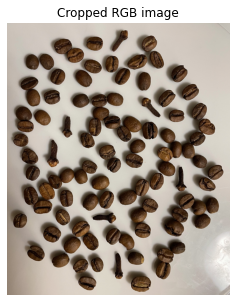

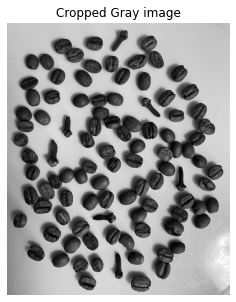

In [4]:
image_gray, image_RGB = get_image("coffeebeans.jpg")

# Cropping for getting the image without any white background 
image_gray = image_gray[330:3670, 130:2860]    #[Row Y, COL, X]
image_RGB = image_RGB[330:3670, 130:2860]   #[Row Y, COL, X]

show_image(image_RGB, label ="Cropped RGB image", size=(12,5))
show_image(image_gray, label ="Cropped Gray image", size=(12,5), cmap='gray')

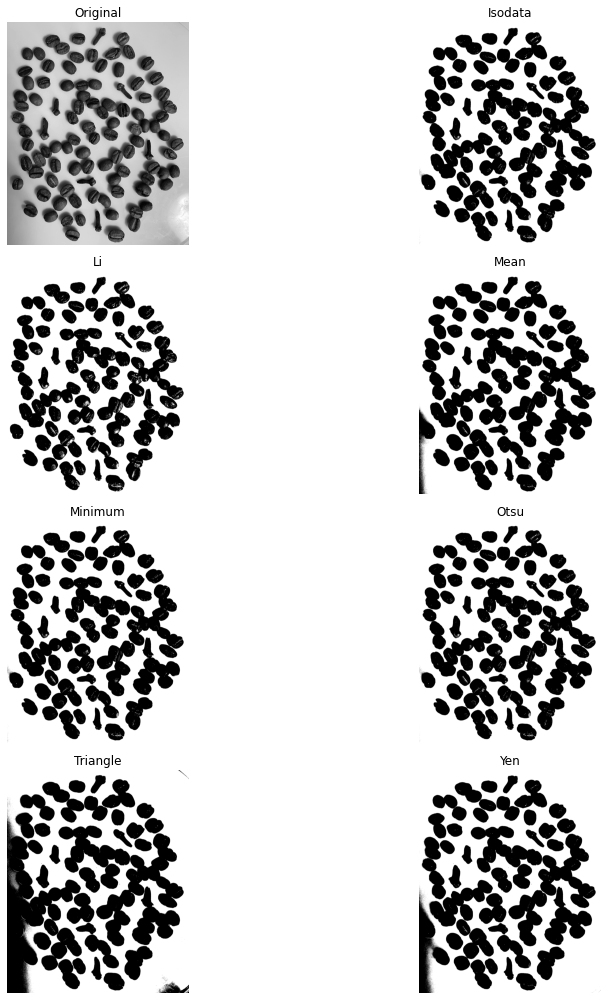

In [5]:
# Trying to find the best thresholding method for binarising the image
fig, ax = try_all_threshold(image_gray, figsize = (15, 14), verbose=False)
plt.show()

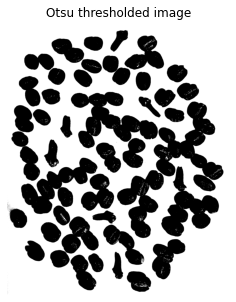

In [6]:
# Binarising the image using the Otsu filter
thresh = threshold_otsu(image_gray)
binary_otsu = image_gray > thresh
show_image(binary_otsu, "Otsu thresholded image", (12,5), cmap='gray')

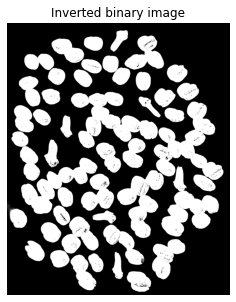

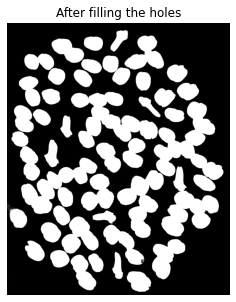

In [7]:
# Filling the holes of the objects in the binary image
inverted_binary_otsu = np.invert(binary_otsu)
show_image(inverted_binary_otsu, "Inverted binary image", (12,5), cmap='gray')
holes_filled = remove_small_holes(inverted_binary_otsu, area_threshold = 8000)
show_image(holes_filled, "After filling the holes", (12,5), cmap='gray')

In [8]:
# #removing noise
# filled_denoised_image = remove_small_objects(holes_filled, 1000)
# show_image(filled_denoised_image, "Image after filling holes and removing small objects", (12,5), cmap='gray')

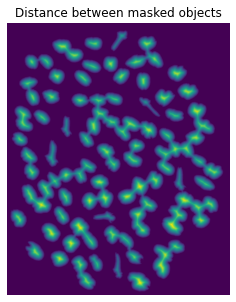

In [9]:
#watershed to sepratae objects

#Step1: Generating the Distance map for understanding the distance between the masked objects
distance = ndi.distance_transform_edt(holes_filled) 
show_image(distance, "Distance between masked objects", (12,5))

In [10]:
import warnings #To ignore a futurewarning about indices
warnings.simplefilter(action ='ignore', category=FutureWarning)

Watershed: https://scikit-image.org/docs/stable/api/skimage.segmentation.html

No of objects detected: 110


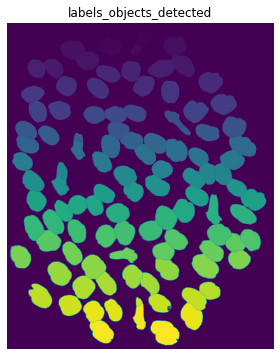

In [11]:
# Step2: Using the watershed for separating the merged objects
# After trying out differnt min_distances, chose 90 as the optimal value. It ensures that local peaks are not to close. Thus helps in the separation of the very close beans.
local_maxi = peak_local_max(distance, 
                            min_distance = 90, 
                            indices = False, 
                            footprint = np.ones((26,26)), 
                            labels = holes_filled.astype(int))
markers = ndi.label(local_maxi)[0]
labels_objects_detected = watershed(-distance, markers, mask = holes_filled, watershed_line = True)
print("No of objects detected:", len(np.unique(labels_objects_detected)))
show_image(labels_objects_detected, "labels_objects_detected", (10,6))



In [12]:
# for i in np.unique(labels_objects_detected):
#     index = np.where(labels_objects_detected==i)
#     plt.text(index[1][0], index[0][1], i, color='red', fontsize=12)
    

In [13]:
# Measuring the properties of the objects detected
labels2 = measure.label(labels_objects_detected)
properties = measure.regionprops(labels2)
print(f'Amount of objects in image: {len(properties)}')

Amount of objects in image: 109


eccentricityfloat
Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.

axis_major_lengthfloat
The length of the major axis of the ellipse that has the same normalized second central moments as the region.

Measure: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

Number of beans: 93


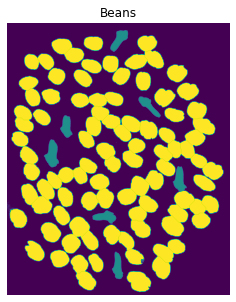

In [14]:
# Finding the beans
truncated_beans = [prop for prop in properties if (prop.eccentricity<=0.901 and prop.area>=25000 
                                                           and prop.major_axis_length >= 100)]

print("Number of beans:", len(truncated_beans))

image_beans = holes_filled[:,:]*1

for obj in truncated_beans:
    for coord in obj.coords:
        image_beans[coord[0], coord[1]] = 2
        
show_image(image_beans, "Beans", (12,5))

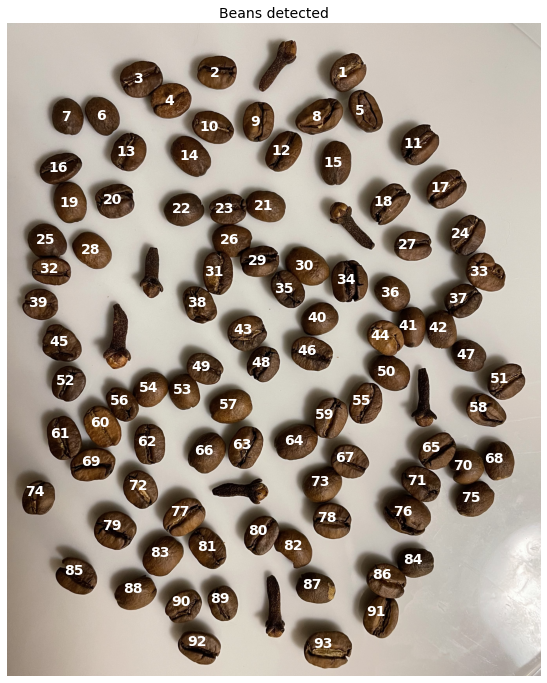

In [15]:
# For counting the beans
# from matplotlib.patches import Circle

# Finding the center points for counting the beans
centers =[]
for prop in truncated_beans:
    y, x = prop.centroid # unpacking the centroids for minimizing the decimal points
    centers.append((round(x, 2), round(y, 2)))
    
# Adding numbers on the beans
plt.subplots(1,1,figsize=(16, 12))
number = 1
for center in centers:
    plt.gca().text(x = center[0], y = center[1], s= str(number), horizontalalignment='center', fontsize = 14,
                   verticalalignment='center', fontweight='extra bold', color='white')
    number+=1
    
# Displaying the detected beans
plt.imshow(image_RGB , cmap='gray')
plt.title(label = "Beans detected", fontsize=14)
plt.axis('off')
plt.show()

In [16]:
# #Adding red rectangles around beans
# rectangles = []

# # Finding the points for making the rectangle
# for obj in truncated_beans:
#     X_values = []
#     Y_values = []
#     for coord in obj.coords:
#         X_values.append(coord[0])
#         Y_values.append(coord[1])
#     min_x = min(X_values) 
#     min_y = min(Y_values)
#     max_x = max(X_values)
#     max_y = max(Y_values)
#     rectangles.append((min_y, min_x, max_y-min_y, max_x-min_x,))

#  # Displaying the detected beans with rectangle patches   
# plt.subplots(1,1,figsize=(25, 22))
# for rec in rectangles:
#     plt.gca().add_patch(Rectangle(xy= (rec[0],rec[1]), width = rec[2], height = rec[3], 
#                                   edgecolor ='red', facecolor ='none', linewidth = 2))

# plt.imshow(image_RGB , cmap='gray')
# plt.title(label = "Beans detected", fontsize=14)
# plt.axis('off')
# plt.show()

In [17]:
# #Finding cloves in image

# cloves = [prop for prop in properties if prop.eccentricity>=0.9
#                                                            and prop.major_axis_length >=280
#                                                            and  prop.area<55000 ]

# print("Number of cloves", len(cloves))


# # image_MM = dilation(filled_denoised_image, footprint = np.ones((2,2)))
# image_cloves = holes_filled[:,:]*1
# for obj in cloves:
#     for coord in obj.coords:
#         image_cloves[coord[0], coord[1]] = 5

# show_image(image_cloves, "image_cloves", (14,5))


In [18]:
# #Adding red rectangles around cloves
# rectangles = []

# for obj in cloves:
#     X_values = []
#     Y_values = []
#     for coord in obj.coords:
#         X_values.append(coord[0])
#         Y_values.append(coord[1])
#     min_x = min(X_values)
#     min_y = min(Y_values)
#     max_x = max(X_values)
#     max_y = max(Y_values)
#     rectangles.append((min_y, min_x, max_y-min_y, max_x-min_x,))


# plt.subplots(1,1,figsize= (12, 6))
# for rec in rectangles:
#     plt.gca().add_patch(Rectangle((rec[0],rec[1]),
#                                   rec[2],rec[3],
#                                   edgecolor='blue',
#                                   facecolor='none',
#                                   lw=1))

# # plt.imshow(image_RGB)
# # plt.title(label = "Cloves detected", fontsize=12)
# # plt.show()


# #Adding red rectangles around beans
# rectangles = []

# for obj in truncated_beans:
#     X_values = []
#     Y_values = []
#     for coord in obj.coords:
#         X_values.append(coord[0])
#         Y_values.append(coord[1])
#     min_x = min(X_values)
#     min_y = min(Y_values)
#     max_x = max(X_values)
#     max_y = max(Y_values)
#     rectangles.append((min_y, min_x, max_y-min_y, max_x-min_x,))


# for rec in rectangles:
#     plt.gca().add_patch(Rectangle((rec[0],rec[1]),
#                                   rec[2],rec[3],
#                                   edgecolor='red',
#                                   facecolor='none',
#                                   lw=1))

# plt.imshow(image_RGB, cmap='gray')
# plt.axis('off')
# plt.show()

# Task4: List of coffee beans positions
Create a list with the center x,y positions of all the coffee beans in the image. (5p)

Skimage measurements, region-groups¶
https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

coords(N, 2) ndarray
Coordinate list (row, col) of the region.


centroid array
Centroid coordinate tuple (row, col).


# 2 (d): 
We know from the geometry, the center x, y positions of an object is called an "centroid" or "geometric center". In the properties of the "measure" module of the skimage, we have an attribute called "centroid". This attribute has the center of the detected object stored as an coordinate tuple (X, Y) or (row, col). Utilizing this attribute, I have created a list of the centroid locations for all the detected beans where the centers are represented in the tuple format. While storing the positions/centers, I have chosen to taken only 2 decimal points for better represendation of the results. 

# 2 (e): 
Similar to the *Exercise 2(d)*, we have obtained the area or the size of the detected objects from the properties of the "measure" module of the skimage. But the areas of the beans are not 100% accurate. Because when the objects were being detected their shadows were not taken into the consideration which is now included in the area of each detected object. 

Detecting the areas without the shadows is quite challending. Because for measuring the objects, we first need to detect the objects. From *Exercise 2(b)*, we can see during the shadow removal a few of beans had newsly developed holes and cracks in them which is not suitable for the watershedding to work properly. Hence, it is quite hard to detect the areas.



In [19]:
# Listing the center of the detected beans
bean_locations =[]
for prop in truncated_beans:
    x, y = prop.centroid # unpacking the centroids for minimizing the decimal points
    bean_locations.append((round(x, 2), round(y, 2)))
print("Number of detected beans:", len(bean_locations))    
print("Centroid of the detected beans:", bean_locations)

# Computing the size/area of the detected beans
bean_areas =[]
for prop in truncated_beans:
    bean_areas.append(prop.area)
    
print("Bean sizes:", bean_areas)

Number of detected beans: 93
Centroid of the detected beans: [(247.33, 1715.44), (248.95, 1060.48), (280.11, 669.31), (394.99, 827.22), (444.7, 1806.83), (470.5, 480.45), (476.29, 302.03), (475.62, 1582.3), (500.07, 1268.59), (527.96, 1035.47), (614.58, 2080.37), (651.19, 1401.08), (652.76, 609.0), (676.04, 930.05), (712.01, 1668.27), (735.89, 261.31), (837.89, 2214.03), (912.24, 1925.48), (913.74, 315.49), (900.67, 540.28), (929.86, 1313.16), (947.83, 893.64), (945.09, 1112.74), (1071.86, 2322.82), (1101.99, 194.89), (1102.7, 1136.11), (1128.62, 2049.74), (1156.53, 428.3), (1211.22, 1279.3), (1236.37, 1519.61), (1268.13, 1058.47), (1254.8, 210.14), (1266.84, 2412.61), (1311.77, 1731.88), (1353.27, 1417.41), (1374.76, 1956.39), (1409.0, 2304.41), (1429.56, 970.16), (1425.61, 158.43), (1505.4, 1585.84), (1545.83, 2054.77), (1555.22, 2205.97), (1567.4, 1206.35), (1594.09, 1908.44), (1628.69, 265.04), (1674.66, 1536.34), (1693.6, 2348.11), (1733.51, 1298.22), (1753.14, 992.12), (1777.86, 

# Task 5. Can you compute the size of the coffee beans? Explain how and/or why it is challenging. (5p)
